In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Matmul and Building a Neural Net in PyTorch - An Exercise in Optimizing Performance

## Matrix Multiplication Refresher

Matrix multiplications are the beating heart of Deep Learning; the so-called magic trick. Before building our Neural Net, using PyTorch, lets quickly run through a refresher of matrix multiplications using various methodologies to achieve the same results and then compare their performance. 

In [2]:
# Importing Libraries
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from torch import tensor

In [3]:
# URL for MNIST dataset
MNIST_URL = "http://deeplearning.net/data/mnist/mnist.pkl"

In [4]:
# Downloading dataset
path = datasets.download_data(MNIST_URL, ext='.gz')
path

PosixPath('/home/bilal/.fastai/data/mnist.pkl.gz')

In [5]:
# Loading training and validation sets directly from the pickle file
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [6]:
# Mapping the datasets into tensors and printing relevant details
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

n, c = x_train.shape

x_train, x_train.shape, y_train, y_train.shape, y_train .min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [7]:
# Creating a testing function to verify details before calculations
import operator

def test(a, b, cmp, cname=None):
    if cname is None: 
        cname = cmp.__name__
    assert cmp(a, b), f"{cname}:\n{a}\n{b}"
        

def test_eq(a, b):
    test(a, b, operator.eq, '==')

In [8]:
# Running tests
assert n == y_train.shape[0] == 50000
# Testing functions
test_eq(c, 28*28) 
test_eq(y_train.min(), 0)
test_eq(y_train.max(), 9)

In [9]:
# Setting colormap for MNIST
mpl.rcParams['image.cmap'] = 'gray'

In [10]:
# Testing image output in a 28x28 format
img = x_train[0]
img.view(28, 28).type()

'torch.FloatTensor'

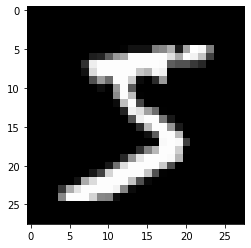

In [11]:
plt.imshow(img.view((28, 28)));

### Standard Python

In [12]:
# Initializing weights and a bias vector
weights = torch.randn(784, 10)
bias = torch.zeros(10)

Doing a matrix multiplication using Python's for loops to get a sense of our slowest results:

In [13]:
# Creating function for matrix multiplication
def matmul(a, b):
    a_row, a_col = a.shape
    b_row, b_col = b.shape
    assert a_col == b_row
    c = torch.zeros(a_row, b_col)
    for i in range(a_row):
        for j in range(b_col):
            for k in range(a_col): # can be swapped with b_row
                c[i, j] += a[i, k] * b[k, j]
    return c

In [14]:
x_valid.shape

torch.Size([10000, 784])

In [15]:
# For m1, we will pick just the first 6 rows, to save time since
# matmul in python is SUPER SLOW!
m1 = x_valid[:5]
m2 = weights

In [16]:
# Getting the shape of our two tensors
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [17]:
# Running our first matrix multiplication 
%time t1 = matmul(m1, m2)

CPU times: user 532 ms, sys: 0 ns, total: 532 ms
Wall time: 531 ms


In [18]:
t1.shape

torch.Size([5, 10])

That's 562 ms for just 6 rows. Imagine if we passed the whole matrix!

Now that we have established our baseline. Let's try to speed the whole process up by a 50,000 times.

#### Element-wise Matmul

In [19]:
# Refactoring the matmul function for element wise operations
def matmul(a, b):
    a_row, a_col = a.shape
    b_row, b_col = b.shape
    assert a_col == b_row
    c = torch.zeros(a_row, b_col)
    for i in range(a_row):
        for j in range(b_col):
            c[i, j] = (a[i, :] * b[:, j]).sum()
    return c

In [20]:
# Running 10 loops of the matmul operation
%timeit -n 10 _= matmul(m1, m2)

798 µs ± 20.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
798 / 5

158.2

This simple refactoring has resulted in a performance boost of approximately 158 times over the previous iteration.

In [22]:
# If we were to export this
# Running the torch.allclose method to test whether two elements
# are elements-wise equal to within a tolerance
def near(a, b):
    return torch.allclose(a, b, rtol=1e-3, atol=1e-5)

def test_near(a, b): 
    test(a, b, near)

In [23]:
# Testing with our first matmul tensor
test_near(t1, matmul(m1, m2))

### Broadcasting

Just to get a sense of what the unsqueeze() method will do, let's run a few tensor operations:

In [24]:
c = tensor([10., 20., 30.])
c, c.shape

(tensor([10., 20., 30.]), torch.Size([3]))

In [25]:
c.unsqueeze(0), c.shape

(tensor([[10., 20., 30.]]), torch.Size([3]))

In [26]:
c.unsqueeze(1), c.shape

(tensor([[10.],
         [20.],
         [30.]]), torch.Size([3]))

In [27]:
c.unsqueeze(-1), c.shape

(tensor([[10.],
         [20.],
         [30.]]), torch.Size([3]))

In [28]:
c[None].shape

torch.Size([1, 3])

In [29]:
c[:, None].shape

torch.Size([3, 1])

In [30]:
# Now we will leverage the performance of C
# with broadcasting to improve matmul's performance
def matmul(a, b):
    a_row, a_col = a.shape
    b_row, b_col = b.shape
    assert a_col == b_row
    c = torch.zeros(a_row, b_col)
    for i in range(a_row):
        c[i] = ((a[i].unsqueeze(-1) * b).sum(dim=0))
    return c

In [31]:
%timeit -n 10 _= matmul(m1, m2)

181 µs ± 9.48 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
810000/181

4550.561797752809

As we can see from the results above, refactoring the matmul() method using broadcasting gives us a performance increase by a whopping 4550 times! 

But this can be improved further with PyTorch's inbuilt implementation of the Einstein Summation and the operator used for matrix multiplications. 

### Einstein Summation and PyTorch Operator

The lesson NB introduces EinSum as:

Einstein summation (`einsum`) is a compact representation for combining products and sums in a general way. From the numpy docs:

"The subscripts string is a comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeated it is summed, so `np.einsum('i,i', a, b)` is equivalent to `np.inner(a,b)`. If a label appears only once, it is not summed, so `np.einsum('i', a)` produces a view of a with no changes."

In [33]:
# Refactoring
def matmul(a, b):
    return torch.einsum('ik, kj->ij', a, b)

In [34]:
%timeit -n 10 _= matmul(m1, m2)

29.5 µs ± 8.01 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
810000/29.2

27739.72602739726

Performance has now gone up by 27740 times!!

The PyTorch operator will give us our best results yet!

In [36]:
%timeit -n 10 t2 = m1.matmul(m2)

6.83 µs ± 3.86 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
# The same operation can be run with 
t2 = m1@m2

In [38]:
test_near(t1, t2)

In [39]:
810000/10

81000.0

The final result is an approximate performance increase of **81,000** times.

## Building a Neural Network From Scratch in PyTorch

### Data Prep

In [40]:
# The lesson notebook uses exports from the previous notebooks for
# all its library imports.
# We won't have to do that for now, so proceeding with loading our datasets.
def get_data():
    # Loads MNIST dataset
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as file:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(file, encoding='latin-1')
        return map(tensor, (x_train, y_train, x_valid, y_valid))

In [41]:
# Normalizing the data sets using broadcasting
def normalize(x, mean, std):
    return (x - mean) / std

In [42]:
# Loading training and validation datasets
x_train, y_train, x_valid, y_valid = get_data()

In [43]:
# Before initializing our weights and biases, let's take a look
# at the training data's mean and std. dev.
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(0.1304), tensor(0.3073))

In [44]:
# Normalizing the training set and validation set
# Making sure to normalize validation set with the
# training set's mean.
x_train = normalize(x_train, train_mean, train_std)

x_valid = normalize(x_valid, train_mean, train_std)

In [45]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(-6.2598e-06), tensor(1.))

In [46]:
# Testing means to within a tolerance range
def test_near_zero(a, tol=1e-3): 
    assert a.abs() < tol
    f"Near zero:{a}"

In [47]:
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

In [48]:
# Shape of the matrices 
n, m = x_train.shape
# No. of activations
c= y_train.max()+1
n, m, c

(50000, 784, tensor(10))

### Basic Architecture of the Forward Pass

In [49]:
# Size of a single hidden layer
nh = 50

In [50]:
# Using simplified init
w1 = torch.randn(m, nh) / math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1) / math.sqrt(nh)
b2 = torch.zeros(1)

In [51]:
# Testing tolerance levels
test_near_zero(w1.mean())
test_near_zero(w1.std() - 1 / math.sqrt(m))

In [52]:
# Checking validation set's means
# mean and std have to be ~ (0, 1)
x_valid.mean(), x_valid.std()

(tensor(-0.0059), tensor(0.9924))

In [55]:
# Creating a linear function for testing
# means
def lin(x, weight, bias):
    return x@weight + bias 

In [56]:
t = lin(x_valid, w1, b1)

In [57]:
t.mean(), t.std()

(tensor(-0.0358), tensor(1.0121))

In [60]:
# Function to rectify negative values
def relu(x):
    return x.clamp_min(0.)

In [61]:
# Adding rectifier to the linear function
t = relu(lin(x_valid, w1, b1))

In [62]:
# The result will not be mean, std ~ (0, 1)
# since the rectifier removed all negative
# values
t.mean(), t.std()
# The paper in the link goes into much detail
# regarding this issue 

(tensor(0.3824), tensor(0.5783))

From pytorch docs: `a: the negative slope of the rectifier used after this layer (0 for ReLU by default)`

$$\text{std} = \sqrt{\frac{2}{(1 + a^2) \times \text{fan_in}}}$$

This was introduced in the paper that described the Imagenet-winning approach from *He et al*: [Delving Deep into Rectifiers](https://arxiv.org/abs/1502.01852)

In [63]:
# Using Kaiming / He init for relu
w1 = torch.randn(m , nh) * math.sqrt(2/m)

In [64]:
w1.mean(), w1.std()

(tensor(4.6473e-05), tensor(0.0502))

In [65]:
# Now that the weight is initalized with he init
# The resulting std is close to one
# However, the mean is still not close to 0
t = relu(lin(x_valid, w1, b1))
t.mean(), t.std()

(tensor(0.5100), tensor(0.8064))

In [67]:
# Checking to see if pytorch's he init
# returns different or similar results
from torch.nn import init

w1 = torch.zeros(m ,nh)
# 'fan_in' and 'fan_in' documentation states
# Choosing 'an_in'preserves the magnitude of the variance 
# of the weights in the forward pass
# 'fan_out' preserves the magnitudes in thebackwards pass.
init.kaiming_normal_(w1, mode='fan_out') 

tensor([[-0.0010, -0.0065, -0.0383,  ...,  0.0180,  0.0282,  0.0561],
        [-0.0291, -0.0643,  0.0306,  ...,  0.0278, -0.0210,  0.0787],
        [ 0.0813, -0.0529, -0.0761,  ...,  0.0544,  0.0651, -0.0536],
        ...,
        [ 0.0300, -0.0257, -0.0540,  ..., -0.0117,  0.0819, -0.0732],
        [ 0.0133, -0.0593, -0.0607,  ..., -0.0266,  0.0202,  0.0476],
        [-0.0773, -0.0134,  0.0382,  ...,  0.0054, -0.0675,  0.0215]])

In [74]:
init.kaiming_normal_??

In [77]:
w1.mean(), w1.std(), w1.shape

(tensor(0.0003), tensor(0.0504), torch.Size([784, 50]))

In [69]:
t = relu(lin(x_valid, w1, b1))

**NOTE**: _The linear layer does not contain a transpose of w1_

In [70]:
# Results are pretty similar to the manual approach
t.mean(), t.std()

(tensor(0.5758), tensor(0.8799))

In [78]:
# Creating a single layer NN
torch.nn.Linear(m, nh).weight.shape

torch.Size([50, 784])

**NOTE:** _PyTorch's version of the linear layer **does** contain a transpose of w1._ 

In [79]:
# Experimenting with a modification in the relu function
# to reduce the mean of the linear function
def relu(x):
    return x.clamp_min(0.) - 0.5

In [80]:
# Retrying initialization
w1 = torch.randn(m, nh) * math.sqrt(2./ m)
t1 = relu(lin(x_valid, w1, b1))
t1.mean(), t1.std()

(tensor(0.0688), tensor(0.8412))

In [82]:
# Function to create our model
def model(x):
    layer1 = lin(x, w1, b1)
    layer2 = relu(layer1)
    layer3 = lin(layer2, w2, b2)
    return layer3

In [83]:
%timeit -n 10 _= model(x_valid)

2.78 ms ± 574 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [85]:
# Testing the output shape of our model
assert model(x_valid).shape == torch.Size([x_valid.shape[0], 1])

### Creating MSE Loss Function for Testing

For testing we will use MSE, instead of Cross Entropy Loss.

In [91]:
def mse(out, targ):
    # Getting rid of unit axis with squeeze
    # Taking care mention the dimension
    # in case there is ever a batch size of size 1
    return (out.squeeze(-1) - targ).pow(2).mean()

In [87]:
# Converting targets to float to calculate the 
# mse
y_train, y_valid = y_train.float(), y_valid.float()

In [88]:
preds = model(x_train)

In [89]:
preds.shape

torch.Size([50000, 1])

In [92]:
# Calculating loss
mse(preds, y_train)

tensor(25.3189)

### Architecture for the Backward Pass and Gradients

Working backwards from our loss calculating layer...

In [98]:
def mse_grad(inp, targ):
    # Gradient loss with respect to output of previous layer
    # storing as an attribute of the input layer 
    inp.g  = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]

In [94]:
def relu_grad(inp, out):
    # Gradient of relu with respect to input activations
    # out.g becomes the gradient of the next layer
    inp.g = (inp > 0).float() * out.g

In [95]:
def lin_grad(inp, out, w, b):  
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [96]:
def forward_and_backward(inp, targ):
    # forward pass
    layer1 = inp @ w1 + b1
    layer2 = relu(layer1)
    out = layer2 @ w2 + b2
    # This loss doesn't appear in the gradients
    # Just so we can print it
    loss = mse(out, targ)
    
    # backward pass
    mse_grad(out, targ)
    lin_grad(layer2, out, w2, b2)
    relu_grad(layer1, layer2)
    lin_grad(inp, layer1, w1, b1)

In [99]:
forward_and_backward(x_train, y_train)

In [100]:
# Cloning the weights and biases of the gradients for testing
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
inp_g = x_train.g.clone()

In [101]:
# Using Pytorch autograd to check out results
xt2 = x_train.clone().requires_grad_(True)
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)

In [102]:
# Creating a forward pass for testing the values cloned above
def forward(inp, targ):
    layer1 = inp @ w12 + b12
    layer2 = relu(layer1)
    out = layer2 @ w22 + b22
    return mse(out, targ)

In [104]:
# Test loss from the cloned training set
test_loss = forward(xt2, y_train)

In [106]:
test_loss.backward()

In [107]:
# Testing the gradients
test_near(w22.grad, w2g)
test_near(b22.grad, b2g)
test_near(w12.grad, w1g)
test_near(b12.grad, b1g)
test_near(xt2.grad, inp_g)

### Refactoring the Model

This becomes very similar to the PyTorch API.

In [123]:
# Refactored version of the relu layer
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.) - 0.5
        return self.out
    
    def backward(self):
        self.inp.g = (self.inp > 0).float() * self.out.g

In [124]:
# Refactored version of the linear layer
class Lin():
    def __init__(self, w, b): 
        self.w = w
        self.b = b
        
    def __call__(self, inp):
        self.inp = inp
        self.out = inp @ self.w + self.b
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
        self.b.g = self.out.g.sum(0)

In [125]:
# Refactored version of the MSE
class MSE():
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (inp.squeeze() - targ).pow(2).mean()
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [126]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = MSE()
        
    def __call__(self, x, targ):
        for l in self.layers:
            x = l(x) # Function composition
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers):
            l.backward()

In [127]:
# Setting all of our previously initialized gradients to zero
w1.g, b1.g, w2.g, b2.g = [None]*4
# Creating model
model = Model(w1, b1, w2, b2)

In [128]:
%time loss = model(x_train, y_train)

CPU times: user 118 ms, sys: 8.14 ms, total: 126 ms
Wall time: 20.9 ms


In [130]:
%time model.backward()

CPU times: user 4.71 s, sys: 2.24 s, total: 6.95 s
Wall time: 1.16 s


In [131]:
# Running tolerance test for gradients
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(inp_g, x_train.g)

### Creating Module Class to Reduce Code Duplication - with additional refactoring

In [132]:
class Module():
    # This class will factor out all of the duplication
    # and works just like nn.Module
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self):
        raise Exception("Not Implemented")
        
    def backward(self):
        self.bwd(self.out, *self.args)

In [133]:
class Relu(Module):
    def forward(self, inp):
        return inp.clamp_min(0.) - 0.5
    
    def bwd(self, out, inp):
        inp.g = (inp > 0).float() * out.g

In [134]:
class Lin(Module):
    def __init__(self, w, b):
        self.w, self.b = w, b
        
    def forward(self, inp):
        return inp @ self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = torch.einsum("bi,bj->ij", inp, out.g)
        self.b.g = out.g.sum(0)

In [ ]:
class MSE(Module):
    def forward(self, inp, targ):
        return (inp.squeeze() - targ).pow(2).mean()
    
    def bwd(self, out, inp, targ):
        inp.g = 2*(inp.squeeze() - targ).unsqueeze(-1) / targ.shape[0]

In [138]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = MSE()
        
    def __call__(self, x, targ):
        for l in self.layers:
            x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers):
            l.backward()

In [139]:
# Resetting the gradients
w1.g, b1.g, w2.g, b2.g = [None]*4
model = Model()

In [140]:
%time loss = model(x_train, y_train)

CPU times: user 110 ms, sys: 1.91 ms, total: 112 ms
Wall time: 18.6 ms


In [142]:
%time model.backward()

CPU times: user 229 ms, sys: 55.5 ms, total: 284 ms
Wall time: 47.5 ms


Our model's performance has increased considerably over the previous refactoring.

### Doing away with einsum()

In [143]:
class Lin(Module):
    def __init__(self, w ,b):
        self.w, self.b = w, b
        
    def forward(self, inp):
        return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [144]:
w1.g, b1.g, w2.g, b2.g = [None]*4
model = Model()

In [145]:
%time loss = model(x_train, y_train)

CPU times: user 123 ms, sys: 5.36 ms, total: 129 ms
Wall time: 21.3 ms


In [146]:
%time model.backward()

CPU times: user 255 ms, sys: 99.2 ms, total: 354 ms
Wall time: 59.1 ms


### Export

In [149]:
!python nn_4m_scratch_script.py Matmul+Building_NN_in_PyTorch.ipynb

python: can't open file 'nn_4m_scratch_script.py': [Errno 2] No such file or directory


/bin/sh: 1: ./nn_4m_scratch_script.py: not found
